<a href="https://colab.research.google.com/github/czneto/TCC/blob/main/NetoCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt


# Estração de documentos

In [ ]:
url = "https://scon.stj.jus.br/SCON/decisoes/toc.jsp?livre=FAIR+USE&b=DTXT&l=50"
# url = "https://scon.stj.jus.br/SCON/jurisprudencia/toc.jsp?livre=FAIR+USE&b=ACOR"

html = urlopen(url)
soup = BeautifulSoup(html, 'html')
documments = soup.find_all(class_=["documento"])

print(len(documments))

10


In [ ]:
result = {"qtd_characters" : []}
title_order = []
for title in documments[0].find_all(class_=["docTitulo"]):
  title_order.append(title.text)
  result[title.text] = []

for doc in documments:
  infos = doc.find_all(class_=["docTexto"])
  for i,title in enumerate(title_order):
    data = infos[i].text
    result[title].append(data)
    if title == "Decisão":
      result["qtd_characters"].append(len(data))

df = pd.DataFrame(result)

In [ ]:
df

,qtd_characters,Processo,Relator(a),Data da Publicação,Decisão,Aceitabilidade Recursal
id_decisoes,,,,,,
0,26760,REsp 1862739,Ministra MARIA ISABEL GALLOTTI,30/03/2021,\n\r\nRECURSO ESPECIAL Nº 1.862.739 - RJ (2019...,provimento
1,23301,REsp 1846969,Ministro PAULO DE TARSO SANSEVERINO,03/12/2020,\n\r\nRECURSO ESPECIAL Nº 1846969 - RJ (2019/0...,provimento
2,16050,AgInt no REsp 1768083,Ministra MARIA ISABEL GALLOTTI,12/08/2020,\n\r\nAgInt no RECURSO ESPECIAL Nº 1.768.083 -...,provimento
3,3981,AREsp 1660048,Ministro PAULO DE TARSO SANSEVERINO,12/08/2020,\n\r\nAGRAVO EM RECURSO ESPECIAL Nº 1660048 - ...,provimento
4,11636,REsp 1849344,Ministra MARIA ISABEL GALLOTTI,10/08/2020,\n\r\nRECURSO ESPECIAL Nº 1849344 - SP (2019/0...,não provimento
5,21451,AgInt no AREsp 1311824,Ministro MARCO AURÉLIO BELLIZZE,30/04/2020,\n\r\nAgInt no AGRAVO EM RECURSO ESPECIAL Nº 1...,provimento parcial
6,23623,AREsp 1628623,Ministro PAULO DE TARSO SANSEVERINO,11/03/2020,\n\r\nAGRAVO EM RECURSO ESPECIAL Nº 1.628.623 ...,provimento
7,16272,TutPrv no AREsp 1530583,Ministra MARIA ISABEL GALLOTTI,13/12/2019,\n\r\nTutPrv no AGRAVO EM RECURSO ESPECIAL Nº ...,provimento
8,19696,AREsp 1265610,Ministro MARCO BUZZI,11/12/2019,\n\r\nAGRAVO EM RECURSO ESPECIAL Nº 1.265.610 ...,não provimento


# Extrator de Aceitação


In [ ]:
def create_positiveness_pattern(words):
  print(words)
  generic_pattern = "("

  pattern = ""
  for pat in words:
    pattern = f"{pattern}\\b{pat}\\b|"

  generic_pattern = f"{generic_pattern}{pattern[:-1]})"

  return generic_pattern

In [ ]:
negative_words = ["não provido","não provimento","nego provimento","negam provimento","não conheço","não conhecimento","nego conhecimento","rejeito","rejeita","rejeitam", "não defiro", "não deferimento", "nego deferimento"]
partial_words = ["parcialmente provido","provimento parcial","parcial provimento", "defiro parcialmente", "parcial deferimento"]
positive_words  = ["provido","provimento","dou provimento","conheço","conheçam", "conheça","conhecimento",
                   "aceito","aceita","aceitam", "defiro", "defiram", "deferimento", "defira"]

acceptness_types = {"negative" :"não provimento",  "neutral" : "provimento parcial","positive" : "provimento", "NaN" : "Não classificado"}          

negative_prefix = ["não", "nego", "negam"]
partial_prefix = ["parcial"]

words = []
words.extend(positive_words)
words.extend(partial_words)
words.extend(negative_words)

In [ ]:
positiveness_pattern = create_positiveness_pattern(words)
positiveness_pattern

['provido', 'provimento', 'dou provimento', 'conheço', 'conheçam', 'conheça', 'conhecimento', 'aceito', 'aceita', 'aceitam', 'defiro', 'defiram', 'deferimento', 'defira', 'parcialmente provido', 'provimento parcial', 'parcial provimento', 'defiro parcialmente', 'parcial deferimento', 'não provido', 'não provimento', 'nego provimento', 'negam provimento', 'não conheço', 'não conhecimento', 'nego conhecimento', 'rejeito', 'rejeita', 'rejeitam', 'não defiro', 'não deferimento', 'nego deferimento']


'(\\bprovido\\b|\\bprovimento\\b|\\bdou provimento\\b|\\bconheço\\b|\\bconheçam\\b|\\bconheça\\b|\\bconhecimento\\b|\\baceito\\b|\\baceita\\b|\\baceitam\\b|\\bdefiro\\b|\\bdefiram\\b|\\bdeferimento\\b|\\bdefira\\b|\\bparcialmente provido\\b|\\bprovimento parcial\\b|\\bparcial provimento\\b|\\bdefiro parcialmente\\b|\\bparcial deferimento\\b|\\bnão provido\\b|\\bnão provimento\\b|\\bnego provimento\\b|\\bnegam provimento\\b|\\bnão conheço\\b|\\bnão conhecimento\\b|\\bnego conhecimento\\b|\\brejeito\\b|\\brejeita\\b|\\brejeitam\\b|\\bnão defiro\\b|\\bnão deferimento\\b|\\bnego deferimento\\b)'

In [ ]:
result_list = []
for i,line in df.iterrows():

  text = line["Decisão"][int(line["qtd_characters"]/2):]

  positiveness_list = re.findall(positiveness_pattern, text , re.IGNORECASE)
  if len(positiveness_list) == 0:
      result_list.append("NaN")
      continue

  last_word = ""
  last_word_p = 0
  for word in positiveness_list:
    p = text.rfind(word)
    if p > last_word_p:
      last_word_p = p
      last_word = word

  last_word = last_word.lower()
  if last_word in positive_words:
    result = acceptness_types["positive"]

    init_postion = last_word_p - 15
    end_postion = last_word_p + len(last_word) + 15
    if  end_postion > len(text):
      end_postion = len(text)
    
    word_range = text[init_postion : end_postion].lower()

    for neg in negative_prefix:
      if neg in word_range:
        result = acceptness_types["negative"]
        break
    
    if result == "positive":
      for neu in partial_prefix:
        if neu in word_range:
          result = acceptness_types["neutral"]
          break

  elif last_word in negative_words:
    result = acceptness_types["negative"]

  elif last_word in partial_words:
    result = acceptness_types["neutral"]

  result_list.append(result)


In [ ]:
df["Aceitabilidade Recursal"] = result_list

In [ ]:
df.index.name='id_decisoes'

In [ ]:
df.to_csv("result.csv")

In [ ]:
def label_function(val):
    return f'{val / 100 * len(df):.0f}\n{val:.0f}%'

Text(0, 0.5, '')

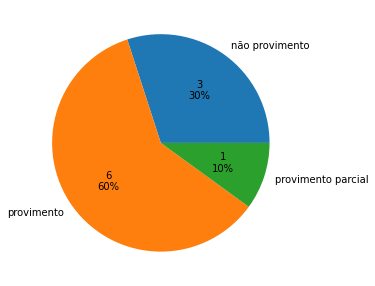

In [ ]:

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 5))

a = df.groupby('Aceitabilidade Recursal').size().plot(kind='pie', autopct=label_function, ax=ax1)

ax1.set_ylabel('')



# Extrator de Leis


In [ ]:
def create_law_pattern():
  generic_pattern = "(art\.|artigo)(.*?)(:"
  patter_list = ["/","CDC", "Código de Defesa do Consumidor" ,
                "CC", "Código Civil", "CF", "Constituição Federal", "CLT", 
                "Consolidação das Leis do Trabalho", "CNJ", 
                "Conselho Nacional de Justiça", 
                "CP", "Código Penal", "CPC", "NCPC", "Código de Processo Civil", 
                "CPM, Código Penal Militar", "CPP" , "Código de Processo Penal", 
                "CPPM" , "Código de Processo Penal Militar", "CRFB", 
                "Constituição da República Federativa do Brasil",
                "CF" ,"Constituição da República Federativa do Brasil", "CTN" , 
                "Código Tributário Nacional", "ECA" ,
                "Estatuto da Criança e do Adolescente"]

  pattern = ""
  for pat in patter_list:
    pattern = f"{pattern}{pat}|"

  generic_pattern = f"{generic_pattern}{pattern[:-1]})"

  return generic_pattern


In [ ]:
law_pattern = create_law_pattern()

In [ ]:
law_pattern

'(art\\.|artigo)(.*?)(:/|CDC|Código de Defesa do Consumidor|CC|Código Civil|CF|Constituição Federal|CLT|Consolidação das Leis do Trabalho|CNJ|Conselho Nacional de Justiça|CP|Código Penal|CPC|NCPC|Código de Processo Civil|CPM, Código Penal Militar|CPP|Código de Processo Penal|CPPM|Código de Processo Penal Militar|CRFB|Constituição da República Federativa do Brasil|CF|Constituição da República Federativa do Brasil|CTN|Código Tributário Nacional|ECA|Estatuto da Criança e do Adolescente)'

In [ ]:
result = {"id_decisoes" : [], "lei" : []}

for i,line in df.iterrows():
  laws_list = re.findall(law_pattern, line["Decisão"], re.IGNORECASE)

  # laws_list = re.findall(law_pattern, line["Decisão"], re.IGNORECASE)
  for law in laws_list:
    law_part = law[1].strip("s").strip(" ")
    if not law_part[0] in "1234567890":
      continue 
      
    result["id_decisoes"].append(i)
    result["lei"].append("".join(law))

In [ ]:
leis_df = pd.DataFrame(result)

In [ ]:
leis_df.to_csv("leis")

# para o futuro

In [ ]:
 a = "DIREITO CIVIL E PROCESSUAL CIVIL. VIOLAÇÃO DE DIREITOS AUTORAIS.REDE SOCIAL. ORKUT. RESPONSABILIDADE CIVIL DO PROVEDOR (ADMINISTRADOR). INEXISTÊNCIA, NO CASO CONCRETO. ESTRUTURA DA REDE E COMPORTAMENTO DO PROVEDOR QUE NÃO CONTRIBUÍRAM PARA A VIOLAÇÃO DE DIREITOS AUTORAIS. RESPONSABILIDADES CONTRIBUTIVA E VICÁRIA. NÃO APLICAÇÃO. INEXISTÊNCIA DE DANOS QUE POSSAM SER EXTRAÍDOS DA CAUSA DE PEDIR. OBRIGAÇÃO DE FAZER. INDICAÇÃO DE URL"

In [ ]:
count = 0
for i,l in df.iterrows():
  if a in l["Decisão"]:
    count += 1
count

6

In [ ]:
h = df["Decisão"].loc[0].split("\n")[2]

In [ ]:
h

'RECURSO ESPECIAL Nº 1.862.739 - RJ (2019/0184715-0)DECISÃOTrata-se de recurso especial interposto por GOOGLE BRASIL INTERNET LTDA., com fundamento nas alíneas "a" e "c" do inciso III do artigo 105 da Constituição Federal, contra acórdão proferido pela Sexta Câmara Cível do Tribunal de Justiça do Estado do Rio de Janeiro, assim ementado (fls. 801/802):APELAÇÃO CÍVEL. OBRIGAÇÃO DE FAZER CUMULADA COM INDENIZAÇÃO POR DANOS MORAIS. RESPONSABILIDADE CIVIL. DANOS À IMAGEM E À HONRA.SITIO DE BUSCA GOOGLE SEARCH. DISPONIBILIZAÇÃO DE INFORMAÇÕES QUE VINCULAM O NOME DOS AUTORES A PREDICATIVOS QUE DEPRECIAM A SUA HONRA. SENTENÇA DE PROCEDÊNCIA. PREVENÇÃO DA CÂMARA. RÉU QUE É PARTE LEGITIMA PARA FIGURAR EM AÇÃO QUE VISA A REMOÇÃO DE CONTEÚDO OFENSIVO, VEICULADO NA INTERNET. NULIDADES, ARGUIDAS SOB O FUNDAMENTO DE INOBSERVÂNCIA DA LEI 12.965/2014, REJEITADAS. MARCO CIVIL DA INTERNET (LEI 12.965 /2014). INAPLICABILIDADE AOS CASOS ANTERIORES A SUA VIGÊNCIA. NOTIFICAÇÃO EXTRAJUDICIAL PARA EXCLUSÃO DO 

In [ ]:
s = 'Part 1. Part 2. Part 3 then more text'

In [ ]:
df

,Processo,Relator(a),Data da Publicação,Decisão
0,REsp 1862739,Ministra MARIA ISABEL GALLOTTI,30/03/2021,\n\r\nRECURSO ESPECIAL Nº 1.862.739 - RJ (2019...
1,REsp 1846969,Ministro PAULO DE TARSO SANSEVERINO,03/12/2020,\n\r\nRECURSO ESPECIAL Nº 1846969 - RJ (2019/0...
2,AgInt no REsp 1768083,Ministra MARIA ISABEL GALLOTTI,12/08/2020,\n\r\nAgInt no RECURSO ESPECIAL Nº 1.768.083 -...
3,AREsp 1660048,Ministro PAULO DE TARSO SANSEVERINO,12/08/2020,\n\r\nAGRAVO EM RECURSO ESPECIAL Nº 1660048 - ...
4,REsp 1849344,Ministra MARIA ISABEL GALLOTTI,10/08/2020,\n\r\nRECURSO ESPECIAL Nº 1849344 - SP (2019/0...
5,AgInt no AREsp 1311824,Ministro MARCO AURÉLIO BELLIZZE,30/04/2020,\n\r\nAgInt no AGRAVO EM RECURSO ESPECIAL Nº 1...
6,AREsp 1628623,Ministro PAULO DE TARSO SANSEVERINO,11/03/2020,\n\r\nAGRAVO EM RECURSO ESPECIAL Nº 1.628.623 ...
7,TutPrv no AREsp 1530583,Ministra MARIA ISABEL GALLOTTI,13/12/2019,\n\r\nTutPrv no AGRAVO EM RECURSO ESPECIAL Nº ...
8,AREsp 1265610,Ministro MARCO BUZZI,11/12/2019,\n\r\nAGRAVO EM RECURSO ESPECIAL Nº 1.265.610 ...
9,REsp 1417851,Ministro LUIS FELIPE SALOMÃO,01/10/2019,\n\r\nRECURSO ESPECIAL Nº 1.417.851 - SP (2013...
